In [ ]:
!rm install1.sh; wget https://raw.githubusercontent.com/HSE-LAMBDA/RheologyReconstruction/colab_try/install1.sh; chmod +x install1.sh;
!rm install2.sh; wget https://raw.githubusercontent.com/HSE-LAMBDA/RheologyReconstruction/colab_try/install2.sh; chmod +x install2.sh;
!rm get_repo.py; wget https://raw.githubusercontent.com/HSE-LAMBDA/RheologyReconstruction/colab_try/get_repo.py; chmod +x get_repo.py;

In [ ]:
! ./install1.sh

In [ ]:
!pip install comet_ml --upgrade

In [3]:
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:34
🔁 Restarting kernel...


Тут ядро умирает, надо заново запускать

In [ ]:
! ./install2.sh

In [2]:
!rm -r *

In [4]:
!python3 get_repo.py

Cloning into 'RheologyReconstruction'...
remote: Enumerating objects: 206, done.
remote: Counting objects: 100% (206/206), done.
remote: Compressing objects: 100% (151/151), done.
remote: Total 206 (delta 76), reused 132 (delta 45), pack-reused 0
Receiving objects: 100% (206/206), 2.46 MiB | 9.11 MiB/s, done.
Resolving deltas: 100% (76/76), done.
From https://github.com/HSE-LAMBDA/RheologyReconstruction
 * branch            dev        -> FETCH_HEAD
hint: Waiting for your editor to close the file... error: unable to start editor 'editor'
Not committing merge; use 'git commit' to complete the merge.
0
0
0
0
0
0
0
0
0
0
0
0
0
0
['RheologyReconstruction/pipeline/dataset.py', 'RheologyReconstruction/pipeline/logger.py', 'RheologyReconstruction/pipeline/metrics.py', 'RheologyReconstruction/pipeline/trainer.py', 'RheologyReconstruction/pipeline/transforms.py', 'RheologyReconstruction/pipeline/utils.py', 'RheologyReconstruction/pipeline/trainer.py', 'RheologyReconstruction/pipeline/dolfin_adjo

# Собственно, программа

Загрузить 2_subdomains_zip.zip

In [5]:
import os

In [6]:
from comet_ml import Experiment
import RheologyReconstruction.pipeline.trainer
import torch
import random
import numpy as np
import os

from RheologyReconstruction.pipeline.dataset import SeismogramDataset
from RheologyReconstruction.pipeline.neural_networks.segnet import SegNet_3Head
from RheologyReconstruction.pipeline.logger import CometMlLogger

In [7]:
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [8]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
ROOT_DIR = os.path.join(os.getcwd(), "RheologyReconstruction", "pipeline")

In [ ]:
from google.colab import files
uploaded = files.upload()

In [11]:
!unzip 2_subdomains_zip.zip
!mv 2_subdomains RheologyReconstruction/pipeline/dolfin_adjoint/2_subdomains
dataset_path = os.path.join(ROOT_DIR, 'dolfin_adjoint', '2_subdomains')
train_dataset = SeismogramDataset(dataset_path)


Archive:  2_subdomains_zip.zip
   creating: 2_subdomains/
   creating: 2_subdomains/seismograms/
  inflating: 2_subdomains/seismograms/0.npy  
   creating: 2_subdomains/masks/
  inflating: 2_subdomains/masks/0.npy  


In [12]:
dataset_path = os.path.join(ROOT_DIR, 'dolfin_adjoint', '2_subdomains')

train_dataset = SeismogramDataset(dataset_path)

In [13]:
from RheologyReconstruction.pipeline.utils import number_of_parameters

model = SegNet_3Head()
number_of_parameters(model)

Total number of parameters: 4567619
Trainable number of parameters: 4567619


In [14]:
import matplotlib.pyplot as plt

def visualize(batch, preds):
    
    preds_lambda = preds[0].detach().cpu().numpy()
    preds_mu     = preds[1].detach().cpu().numpy()
    preds_rho    = preds[2].detach().cpu().numpy()
    
    idx = 0
    
    fig, axes = plt.subplots(3, 2, figsize=(10, 18))
    axes[0][0].imshow(preds_lambda[idx])
    axes[0][0].set_title('predictions for \n lambda distr.')
    axes[0][0].axis('off')
    axes[0][1].imshow(batch.masks[idx].cpu().data.numpy())
    axes[0][1].set_title('true lambda distr')
    axes[0][1].axis('off')
    
    axes[1][0].imshow(preds_mu[idx])
    axes[1][0].set_title('predictions for \n mu distr.')
    axes[1][0].axis('off')
    axes[1][1].imshow(batch.masks[idx].cpu().data.numpy())
    axes[1][1].set_title('true mu distr')
    axes[1][1].axis('off')
    
    axes[2][0].imshow(preds_rho[idx])
    axes[2][0].set_title('predictions for \n rho distr.')
    axes[2][0].axis('off')
    axes[2][1].imshow(batch.masks[idx].cpu().data.numpy())
    axes[2][1].set_title('true rho distr')
    axes[2][1].axis('off')
              
    return fig

In [15]:
experiment = Experiment(
    api_key="dMLdaEjHpSSAclMOlMSQxkriB",
    project_name="rheology-reconstruction",
    workspace="stankevich-mipt",
    auto_metric_logging=False
)

params = {
  "model"    : "Segnet with regular convolutions",
  "grid_size":"10x10",
  "lr"       :"1e-3",
  "numerical solver":"adjoint_equation",
  "dataset": "2 subdomains"
}

experiment.log_parameters(params)

logger = CometMlLogger(
    experiment,
    log_interval=1,
    val_interval=1,
    visualize=visualize
)

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/stankevich-mipt/rheology-reconstruction/16c415d04a754d56a72e0acd6361749e



In [17]:
from RheologyReconstruction.pipeline.trainer import BaseTrainer

# NB: such format for coordinates is required for dolfin_adjoint to 
# pass grads through indexing. Why? God knows

detector_coords = [(np.array([c, 2000.])) for c in np.linspace(0., 2000., 128)]

# TODO: test with nonempty logger
t = BaseTrainer(model, 
                device, 
                train_dataset,
                optimizer_type=torch.optim.Adam,
                optimizer_params={'lr': 1e-3},
                snapshot_interval=250,
                logger=logger)

In [20]:
!mkdir dolfin_adjoint
!cp RheologyReconstruction/pipeline/dolfin_adjoint/solver_config.yaml dolfin_adjoint/solver_config.yaml 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Running training procedure:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1 of 100:   0%|          | 0/1 [00:00<?, ?it/s]

integrating the state problem:   0%|          | 0/199 [00:00<?, ?it/s]

integrating adjoint problem in reverse time:   0%|          | 0/199 [00:00<?, ?it/s]

Epoch 2 of 100:   0%|          | 0/1 [00:00<?, ?it/s]

integrating the state problem:   0%|          | 0/199 [00:00<?, ?it/s]

integrating adjoint problem in reverse time:   0%|          | 0/199 [00:00<?, ?it/s]

Epoch 3 of 100:   0%|          | 0/1 [00:00<?, ?it/s]

integrating the state problem:   0%|          | 0/199 [00:00<?, ?it/s]

integrating adjoint problem in reverse time:   0%|          | 0/199 [00:00<?, ?it/s]

Epoch 4 of 100:   0%|          | 0/1 [00:00<?, ?it/s]

integrating the state problem:   0%|          | 0/199 [00:00<?, ?it/s]

integrating adjoint problem in reverse time:   0%|          | 0/199 [00:00<?, ?it/s]

Epoch 5 of 100:   0%|          | 0/1 [00:00<?, ?it/s]

integrating the state problem:   0%|          | 0/199 [00:00<?, ?it/s]

integrating adjoint problem in reverse time:   0%|          | 0/199 [00:00<?, ?it/s]

Epoch 6 of 100:   0%|          | 0/1 [00:00<?, ?it/s]

integrating the state problem:   0%|          | 0/199 [00:00<?, ?it/s]

integrating adjoint problem in reverse time:   0%|          | 0/199 [00:00<?, ?it/s]

Epoch 7 of 100:   0%|          | 0/1 [00:00<?, ?it/s]

integrating the state problem:   0%|          | 0/199 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

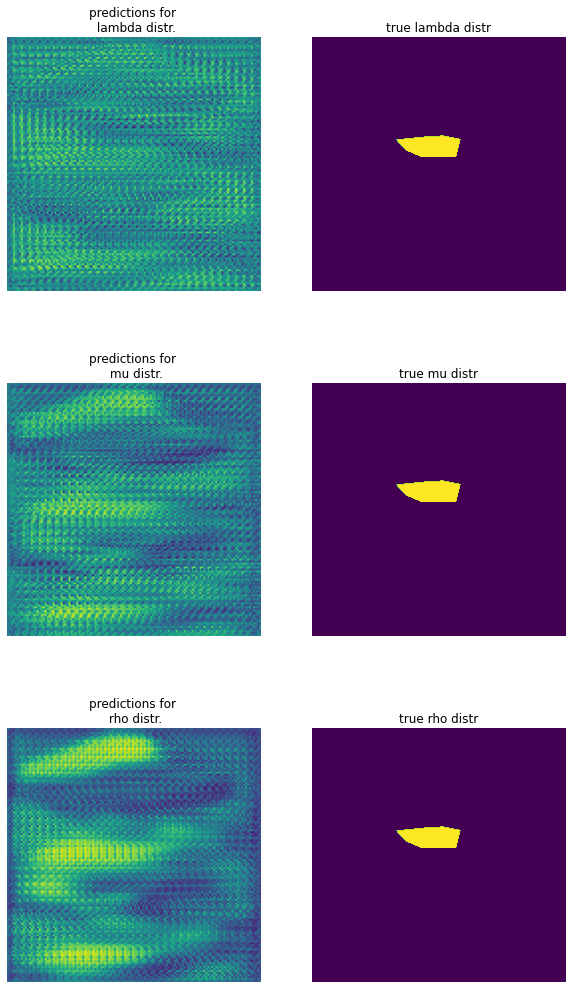

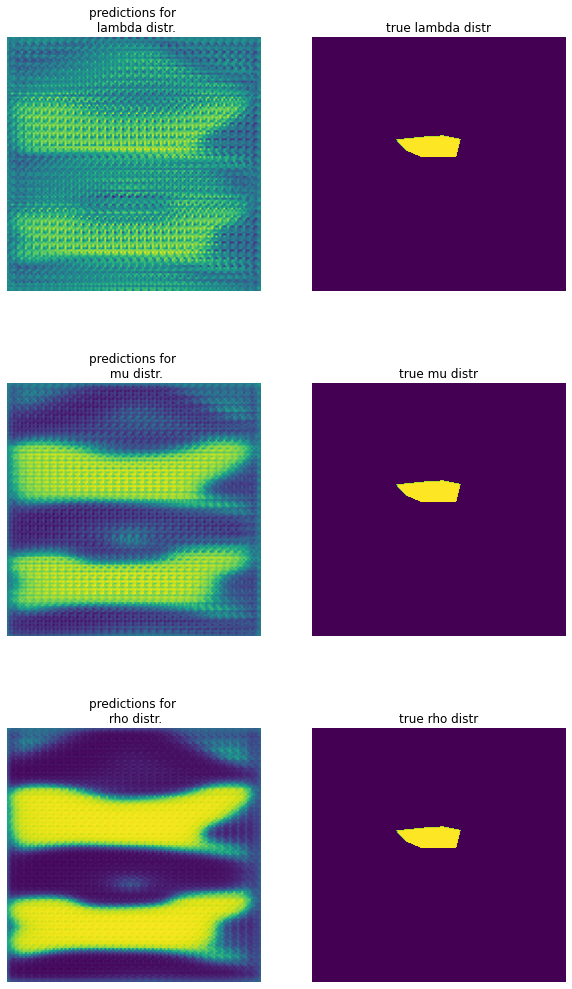

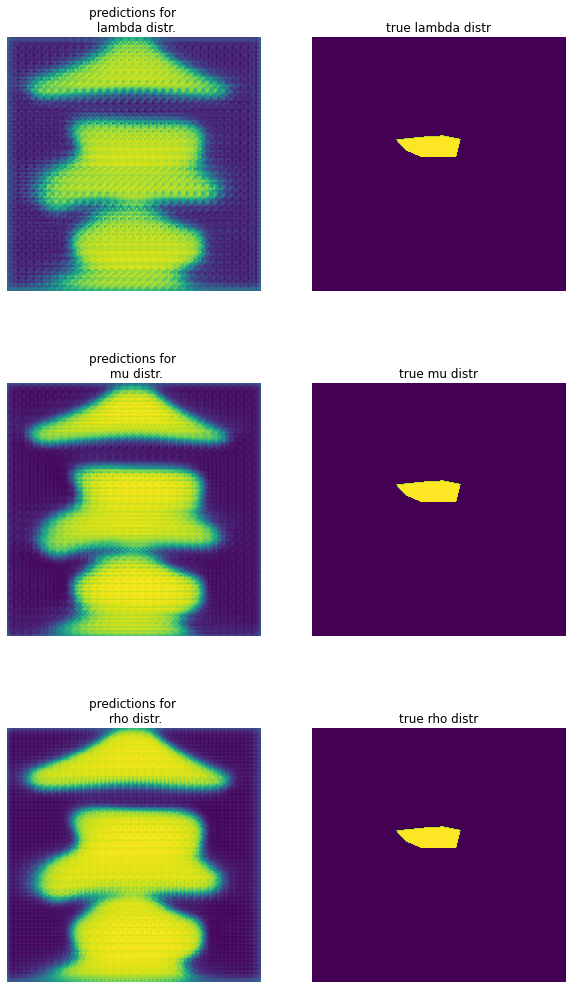

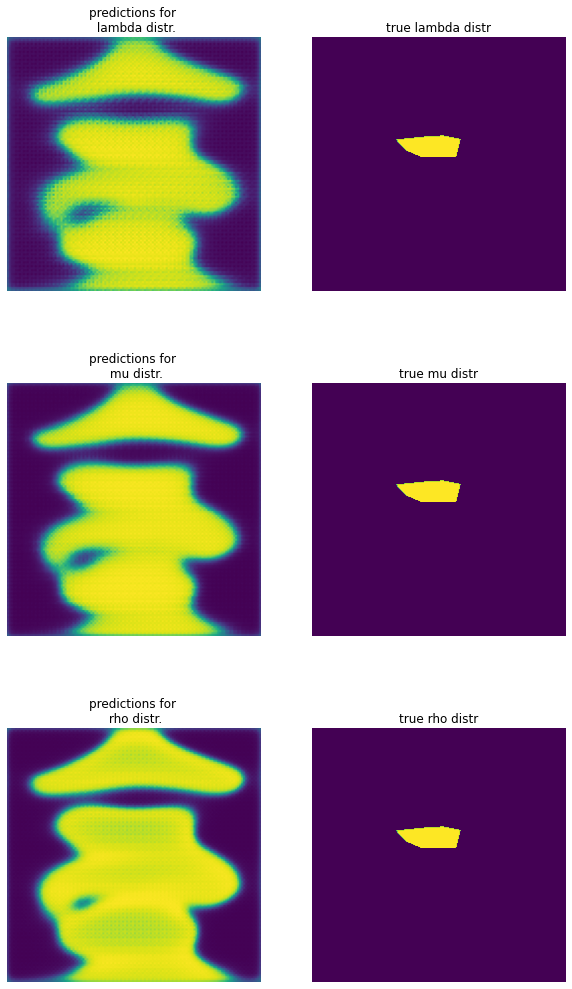

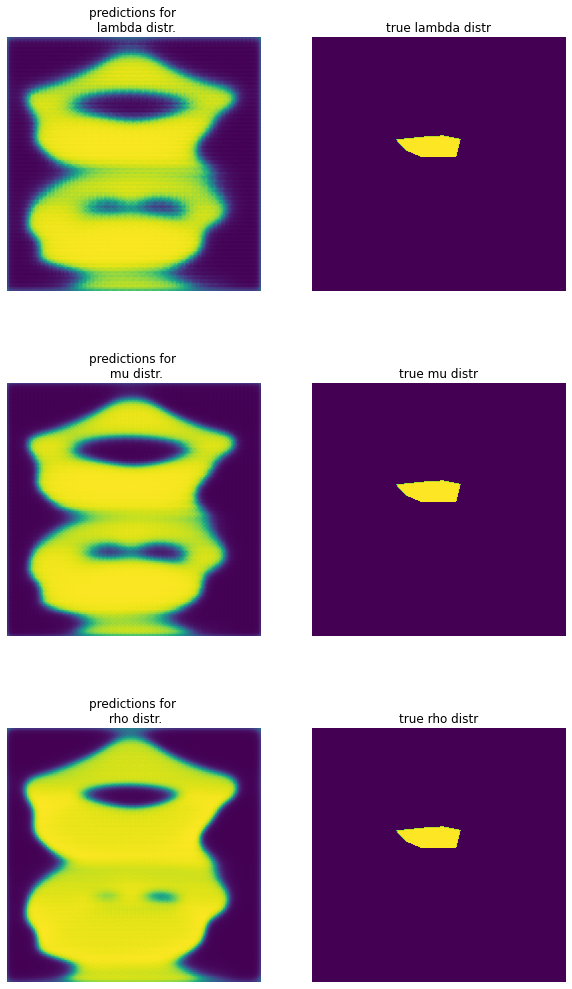

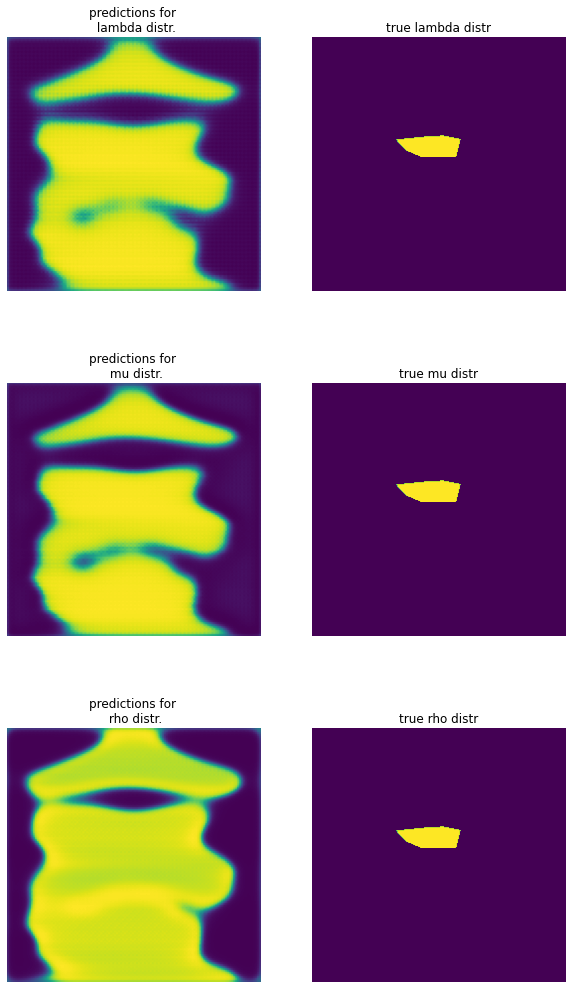

In [21]:
t.train(detector_coords, batch_size=1, epochs=100, num_solver_type='adjoint_equation')

In [18]:
experiment.end()